In [1]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 6.3MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=2e4da46880dd5aa55c268129e3c2eb2a2ef0b2f5966d3c4d58e5022f9af01d47
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.fftpack
import random
%matplotlib inline

In [5]:
def StockStatsCheck(df):

  dfMean = (df['High']+df['Low'])/2

  meanArrSer =  dfMean.groupby(pd.Grouper(freq='1d')).mean().dropna()
  stdArrSer  =  dfMean.groupby(pd.Grouper(freq='1d')).std().dropna()
  #print('groups = ',meanArrSer)
  #print(meanArr)
  #print(stdArr)

  meanArr = np.array(meanArrSer.values)
  stdArr = np.array(stdArrSer.values)

  #print(abs(1-meanArr[:-1]/meanArr[1:]))
  #print(abs(1-meanArr[:-1]/meanArr[1:]) < MEAN_FLUCT * ARB_VAL)
  #print(stdArr/meanArr)
  #print(stdArr/meanArr >  STD_TO_ARB * ARB_VAL)

  c1_mean_val = np.abs(1-meanArr[:-1]/meanArr[1:])
  c2_std_val = (STD_TO_ARB*stdArr)/meanArr

  #print(c1_mean_val)

  c1_mean = c1_mean_val < MEAN_FLUCT * ARB_VAL
  c2_std = c2_std_val > ARB_VAL

  #print(c1,c2)
  c_tot = all(c1_mean) and all(c2_std) and (len(c1_mean)>0) and (len(c2_std)>0)
  if (c_tot): print (c1_mean,c2_std)
  return c_tot,c1_mean_val,c2_std_val

In [6]:
#### Initialization ###

ARB_VAL = 0.005
MEAN_FLUCT = 0.5
STD_TO_ARB = 3

tickers = list(pd.read_csv('/content/Nasdaq100_TickersOnly.csv')['Ticker'])
print(tickers)
# tickers = ["LBTYA"]
start = '2020-09-20'
end = '2020-11-17'

SCAN_WIN_DAYS = 2

startDT = pd.to_datetime(start)
endDT = pd.to_datetime(end)

startDT = startDT.tz_localize(tz='America/New_York')
endDT = endDT.tz_localize(tz='America/New_York')

DEL_T = pd.Timedelta(days=SCAN_WIN_DAYS)
ONE_DAY = pd.Timedelta(days=1)
tmpDT = startDT

['ATVI', 'ADBE', 'AMD', 'ALXN', 'ALGN', 'GOOGL', 'GOOG', 'AMZN', 'AAL', 'AMGN', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ASML', 'ADSK', 'ADP', 'BIDU', 'BIIB', 'BMRN', 'BKNG', 'AVGO', 'CDNS', 'CDW', 'CERN', 'CHTR', 'CHKP', 'CTAS', 'CSCO', 'CTXS', 'CTSH', 'CMCSA', 'CPRT', 'CSGP', 'COST', 'CSX', 'DLTR', 'EBAY', 'EA', 'EXC', 'EXPE', 'FB', 'FAST', 'FISV', 'FOXA', 'FOX', 'GILD', 'IDXX', 'ILMN', 'INCY', 'INTC', 'INTU', 'ISRG', 'JD', 'KLAC', 'KHC', 'LRCX', 'LBTYA', 'LBTYK', 'LULU', 'MAR', 'MXIM', 'MELI', 'MCHP', 'MU', 'MSFT', 'MDLZ', 'MNST', 'NTAP', 'NTES', 'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PCAR', 'PAYX', 'PYPL', 'PEP', 'QCOM', 'REGN', 'ROST', 'SGEN', 'SIRI', 'SWKS', 'SPLK', 'SBUX', 'SNPS', 'TMUS', 'TTWO', 'TSLA', 'TXN', 'TCOM', 'ULTA', 'UAL', 'VRSN', 'VRSK', 'VRTX', 'WBA', 'WDAY', 'WDC', 'WLTW', 'XEL', 'XLNX']


In [7]:
#### Find Best Stocks to Trade ###

# This ugly code should be fixed...
df = yf.download('MSFT', start , end ,interval='2m',progress=False)
days = sorted(set(df.index.date))
days = [x.strftime('%Y-%m-%d') for x in days]
# good_tcks = {i:[] for i in range(len(days))}
good_tcks = {day:[] for day in days}
print(good_tcks.keys())
for tck in tickers:
  df = yf.download(tck, start , end ,interval='2m',progress=False)
  days = sorted(set(df.index.date))
  days = [x.strftime('%Y-%m-%d') for x in days]
  df['date'] = df.index
  df['date'] = df['date'].apply(lambda x:x.strftime('%Y-%m-%d') )
  # while (tmpDT + DEL_T <= endDT):
  for i in range(len(days)-SCAN_WIN_DAYS-1):
    rel_days = '|'.join(days[i:i+SCAN_WIN_DAYS])
    df_new = df[df['date'].str.contains(rel_days)]
    
    ### Find "good" stocks
    c_tot,c1_mean_val,c2_std_val = StockStatsCheck(df_new)    
    if (c_tot):
      print(tck,' ',days[i])
      # good_tcks[i+SCAN_WIN_DAYS].append((tck, c1_mean_val, c2_std_val))
      good_tcks[days[i+SCAN_WIN_DAYS]].append((tck, c1_mean_val, c2_std_val))

dict_keys(['2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16', '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30', '2020-11-02', '2020-11-03', '2020-11-04', '2020-11-05', '2020-11-06', '2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12', '2020-11-13', '2020-11-16'])
[ True] [ True  True]
ATVI   2020-10-16
[ True] [ True  True]
ATVI   2020-10-22
[ True] [ True  True]
ATVI   2020-10-23
[ True] [ True  True]
ATVI   2020-11-02
[ True] [ True  True]
ADBE   2020-10-07
[ True] [ True  True]
ADBE   2020-10-20
[ True] [ True  True]
ADBE   2020-10-22
[ True] [ True  True]
ADBE   2020-10-30
[ True] [ True  True]
ADBE   2020-11-11
[ True] [ True  True]
AMD   2020-10-05
[ True] [ True  True]
AMD   2020-10-15
[ True] [ True  True]
ALXN   2020-10-09
[ True] [ True  True]
ALXN   2020-10-12
[ True] [ True  True]
ALXN   2020-10

In [ ]:
print(good_tcks)

{0: [], 1: [], 2: [('ATVI', array([0.00467401]), array([0.01070755, 0.02098698])), ('AMD', array([0.00199322]), array([0.02296424, 0.01968275])), ('BIIB', array([0.00474735]), array([0.02187391, 0.01235001])), ('BMRN', array([0.00470796]), array([0.01723664, 0.01725388])), ('DLTR', array([0.00487245]), array([0.01161456, 0.02547367])), ('FOXA', array([0.00183373]), array([0.01584509, 0.02977211])), ('FOX', array([0.00242494]), array([0.01676181, 0.02939496])), ('IDXX', array([0.00201829]), array([0.01093731, 0.01881359])), ('ILMN', array([0.00443163]), array([0.01531744, 0.01616506])), ('ISRG', array([0.00370974]), array([0.01016846, 0.01603032])), ('LULU', array([0.0022526]), array([0.0188016 , 0.02391034])), ('MNST', array([0.00024013]), array([0.01021433, 0.01593136])), ('NFLX', array([0.00216876]), array([0.01926493, 0.01850175])), ('PAYX', array([0.00114482]), array([0.01102398, 0.02990783])), ('ROST', array([0.00040539]), array([0.01049879, 0.02729834])), ('SGEN', array([0.003913

In [9]:
### Test with random stocks ###
profit = 1
success_count=0;
fail_count = 0;

for i in range(len(good_tcks) - SCAN_WIN_DAYS - 1):
  
  ticker_to_trade = random.choice(tickers)

  df_today = yf.download(ticker_to_trade, days[i+SCAN_WIN_DAYS-1] , days[i+SCAN_WIN_DAYS] ,interval='2m',progress=False)
  df_mean_today = (df_today['High']+df_today['Low'])/2
  mean_today_value = df_mean_today.median()
  buyPrice = mean_today_value *(1-ARB_VAL)
  sellPrice = buyPrice *(1+ARB_VAL)
  print(days[i+SCAN_WIN_DAYS] , days[i+SCAN_WIN_DAYS+1])
  df_tommorow = yf.download(ticker_to_trade, days[i+SCAN_WIN_DAYS] , days[i+SCAN_WIN_DAYS+1] ,interval='2m',progress=False)

  # intra-day dynamic trade check
  tommorow_highs = df_tommorow['High']
  tommorow_lows = df_tommorow['Low']

  buySuccess = (buyPrice > tommorow_lows)
  
  if (len(tommorow_lows[buySuccess])>0):
    firstBuyTime = tommorow_lows[buySuccess].index[0]
    sellSuccess = (sellPrice < tommorow_highs)
    if (len(tommorow_highs[sellSuccess])>0):
      lastSellTime = tommorow_highs[sellSuccess].index[-1]
      tradeSuccess = lastSellTime > firstBuyTime
    else:
      tradeSuccess = False
    
    if (tradeSuccess):
      profit *= 1 + (sellPrice - buyPrice)/buyPrice
      success_count+=1
    else:
      profit *= 0.995#1 + (df_tommorow['Low'][-1] - buyPrice)/buyPrice
      fail_count+=1

  print(days[i+SCAN_WIN_DAYS],' : p=',profit,'\n', ticker_to_trade, buyPrice)

print('')
print('total p=',profit)
print('success rate= ',success_count/(success_count+fail_count))


2020-10-07 2020-10-08
2020-10-07  : p= 1.005 
 REGN 586.5823487854004
2020-10-08 2020-10-09
2020-10-08  : p= 1.005 
 ANSS 324.14362899780275
2020-10-09 2020-10-12
2020-10-09  : p= 1.005 
 ADSK 232.84243825912475
2020-10-12 2020-10-13
2020-10-12  : p= 1.005 
 TXN 150.01118198394775
2020-10-13 2020-10-14
2020-10-13  : p= 0.9999749999999998 
 UAL 36.28759997367859
2020-10-14 2020-10-15
2020-10-14  : p= 0.9949751249999998 
 KLAC 218.92486892700194
2020-10-15 2020-10-16
2020-10-15  : p= 0.9900002493749999 
 BIIB 287.87588203430175
2020-10-16 2020-10-19
2020-10-16  : p= 0.9949502506218748 
 CHKP 127.24557712554932
2020-10-19 2020-10-20
2020-10-19  : p= 0.9899754993687654 
 BIIB 279.8536945343018
2020-10-20 2020-10-21
2020-10-20  : p= 0.9949253768656091 
 TCOM 30.031587386131285
2020-10-21 2020-10-22
2020-10-21  : p= 0.999900003749937 
 WLTW 210.67135334014893
2020-10-22 2020-10-23
2020-10-22  : p= 1.0048995037686865 
 NTES 87.82865045547486
2020-10-23 2020-10-26
2020-10-23  : p= 1.0048995037

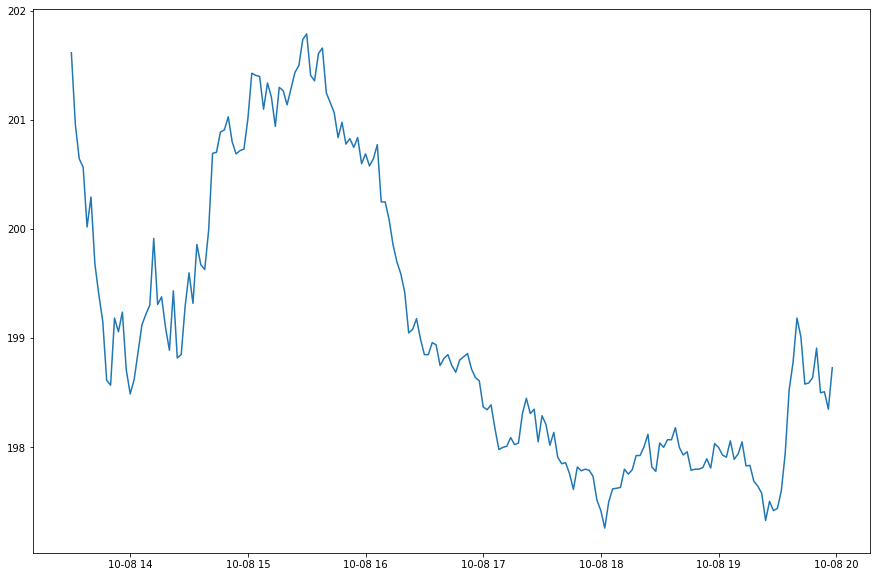

In [ ]:
df = yf.download('SGEN', '2020-10-08' , '2020-10-09' ,interval='2m',progress=False)

fig1 = plt.figure(figsize=(15,10))
plt.plot(df['Close'])


In [10]:
#### Intra-day Dynamic Trade Simulation ###
ARB_VAL = 0.005
profit = 1
df = yf.download('MSFT', start , end ,interval='2m',progress=False)
days = sorted(set(df.index.date))
days = [x.strftime('%Y-%m-%d') for x in days]
# days = sorted(days)
# print(days)
STOP_LOSS_FRAC = 6
DROP_BEF_BUY = 2

success_count=0;
fail_count = 0;

for i in range(len(good_tcks) - SCAN_WIN_DAYS - 1):
  if(good_tcks[days[i]]!=[]):

    good_tcks_mean_c2=[]
    for j in range(len(good_tcks[days[i]])):
      good_tcks_mean_c2.append(good_tcks[days[i]][j][2].mean())

    good_tcks_mean_c2 = np.array(good_tcks_mean_c2)
    indices = good_tcks_mean_c2.argsort()[-1:]
    daily_profit_array = []
    
    for k in indices:#range(len(good_tcks[days[i]])):
      idx_to_trade = k#good_tcks_mean_c2.argmax()
      ticker_to_trade = good_tcks[days[i]][idx_to_trade][0]
    
    #df_today = yf.download(ticker_to_trade, days[i+SCAN_WIN_DAYS-1] , days[i+SCAN_WIN_DAYS] ,interval='2m',progress=False)
    #df_mean_today = (df_today['High']+df_today['Low'])/2
    #mean_today_value = df_mean_today.median()
    #buyPrice = mean_today_value *(1-ARB_VAL)
    #sellPrice = buyPrice *(1+ARB_VAL)
    #print(days[i+SCAN_WIN_DAYS] , days[i+SCAN_WIN_DAYS+1])
      df_trade_day = yf.download(ticker_to_trade, days[i+1] , days[i+2] ,interval='2m',progress=False)

    
    ### intra-day dynamic trade check
      trade_day_highs = df_trade_day['High']
      trade_day_lows = df_trade_day['Low']

      trade_day_val = (trade_day_highs + trade_day_lows)/2
    
      start_trade_index = 1#round(0.20*len(trade_day_val))
      intra_day_profit = 1
      while start_trade_index < 2:#0.3*len(trade_day_val):
        tradeSuccess = False
        buySuccess = False;
        stop_trade_index = round(0.7*len(trade_day_val))
        for j in range(start_trade_index,stop_trade_index-2):
          if (trade_day_val[j] < (1-DROP_BEF_BUY*ARB_VAL)*trade_day_val[start_trade_index:j-1].max()):
            J=j+1
            buyPrice = trade_day_val[J]
            buySuccess=True
            break

        if (buySuccess):
          sellOpt = trade_day_val[J+1:] > buyPrice * (1+ARB_VAL)
          lossOpt = trade_day_val[J+1:] < buyPrice * (1-STOP_LOSS_FRAC*ARB_VAL)
        
          sellOpt = np.array(sellOpt.values)
          lossOpt = np.array(lossOpt.values)

          sellIndx = np.argwhere(sellOpt==True)
          lossIndx = np.argwhere(lossOpt==True)

          if (len(lossIndx) > 0 and len(sellIndx) > 0):
            isLoss = lossIndx[0] < sellIndx[0]
          if (len(lossIndx) == 0): isLoss = False
          if (len(sellIndx) == 0): isLoss = True
          

          if (any(sellOpt) and (not isLoss)):
            tradeSuccess = True
            sellPrice = buyPrice * (1+ARB_VAL)

        if (tradeSuccess):
          intra_day_profit *= (1 + (sellPrice - buyPrice)/buyPrice)
          success_count+=1
          print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, buyPrice)
          print(J, sellIndx[0] + J + 1, stop_trade_index)
          start_trade_index = sellIndx[0][0] + J + 1
        elif (buySuccess):
          intra_day_profit *= (max((1-STOP_LOSS_FRAC*ARB_VAL), 1+(trade_day_val[J+1:].values[-1]- buyPrice)/buyPrice))
          fail_count+=1
          print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, 'LOSS!')
          if len(lossIndx) > 0: start_trade_index = lossIndx[0][0] + J + 1
          else: start_trade_index = len(trade_day_val)
        else:
          # daily_profit_array.append(1)
          print(days[i+1],' :   daily_p=',intra_day_profit,' <--->', ticker_to_trade, 'No Deal')
          start_trade_index = len(trade_day_val)
      daily_profit_array.append(intra_day_profit)
    print(daily_profit_array)
    profit *= np.array(daily_profit_array).mean()
    print(days[i+1],' : total_p=',profit)


    #Static Deal Sim ####
    #simDayHigh, simDayLow = max(df_tommorow['High']), min(df_tommorow['Low'])
    #if simDayLow < buyPrice:
    #  if sellPrice < simDayHigh:
    #    profit *= 1 + (sellPrice - buyPrice)/buyPrice
    #    success_count+=1
    #  else:
    #    profit *= 0.995
    #    fail_count+=1
    
    
    
    
    
print('')
print('total p=',profit)
print('Trade Count =',success_count+fail_count,' Success rate= ',success_count/(success_count+fail_count))

2020-10-08  :   daily_p= 1.005  <---> FOX 29.244999885559082
18 [142] 134
[1.005]
2020-10-08  : total_p= 1.005
2020-10-09  :   daily_p= 1.005  <---> INCY 94.125
50 [59] 136
[1.005]
2020-10-09  : total_p= 1.0100249999999997
2020-10-12  :   daily_p= 1  <---> MAR No Deal
[1]
2020-10-12  : total_p= 1.0100249999999997
2020-10-13  :   daily_p= 0.9995757221634836  <---> SIRI LOSS!
[0.9995757221634836]
2020-10-13  : total_p= 1.0095964687781722
2020-10-14  :   daily_p= 0.9978424637655008  <---> ALXN LOSS!
[0.9978424637655008]
2020-10-14  : total_p= 1.007418227814561
2020-10-15  :   daily_p= 1.005  <---> SNPS 223.03500366210938
28 [48] 131
[1.005]
2020-10-15  : total_p= 1.0124553189536336
2020-10-16  :   daily_p= 1  <---> EBAY No Deal
[1]
2020-10-16  : total_p= 1.0124553189536336
2020-10-19  :   daily_p= 1.005  <---> ADSK 264.739990234375
38 [88] 136
[1.005]
2020-10-19  : total_p= 1.0175175955484017
2020-10-20  :   daily_p= 1  <---> ISRG No Deal
[1]
2020-10-20  : total_p= 1.0175175955484017
2020